In [1]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pickle
import pandas as pd
import nltk
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/final_bigram_counts.p','rb')
final_bigram_counts=pickle.load(filename)
filename.close()

In [4]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/text_tf_idf.p','rb')
text_tf_idf=pickle.load(filename)
filename.close()

In [5]:
filename=open('/content/drive/MyDrive/Colab Notebooks/Amazon Fine Food Reviews/amazon_data.p','rb')
amazon_data=pickle.load(filename)
filename.close()

In [6]:
amazon_data.head()

,Score,Time,Text
138706,1,939340800,everi book educ witti littl book make son laug...
138683,1,940809600,whole seri great way spend time child rememb s...
417839,1,944092800,entertainingl funni beetlejuic well written mo...
417859,1,944438400,modern day fairi tale twist rumplestiskin capt...
417838,1,946857600,fantast beetlejuic excel funni movi keaton hil...


# Positive and Negative Words

In [7]:
amazon_data_positive =amazon_data[amazon_data['Score'] == 1]['Text']
amazon_data_negative = amazon_data[amazon_data['Score'] == 0]['Text']

In [8]:
#getting themost frequent words in both the categories(Positive and Negative)
#separating postive and negative reviews into separate dataframes 


i=0
positive_words =[]
negative_words = []

for sent in amazon_data_positive.values:
    for w in sent.split():
        positive_words.append(w)
        
    
for sent in amazon_data_negative.values:
    for w in sent.split():
          negative_words.append(w)
        
positive_words_freq = nltk.FreqDist(positive_words)
negative_words_freq = nltk.FreqDist(negative_words)

print("the most common positive words:" , positive_words_freq.most_common(15))
print("the most common negative words:" , negative_words_freq.most_common(15))

the most common positive words: [('not', 295377), ('great', 150202), ('like', 145726), ('tast', 144093), ('good', 142359), ('love', 130000), ('flavor', 118230), ('use', 104931), ('product', 102820), ('one', 99347), ('tea', 95689), ('coffe', 90365), ('tri', 87632), ('make', 76867), ('get', 73099)]
the most common negative words: [('not', 106688), ('tast', 39146), ('like', 34979), ('product', 30334), ('would', 23701), ('flavor', 21452), ('one', 21171), ('tri', 17899), ('good', 17613), ('coffe', 15944), ('no', 15877), ('use', 15753), ('buy', 14950), ('get', 14156), ('order', 13426)]


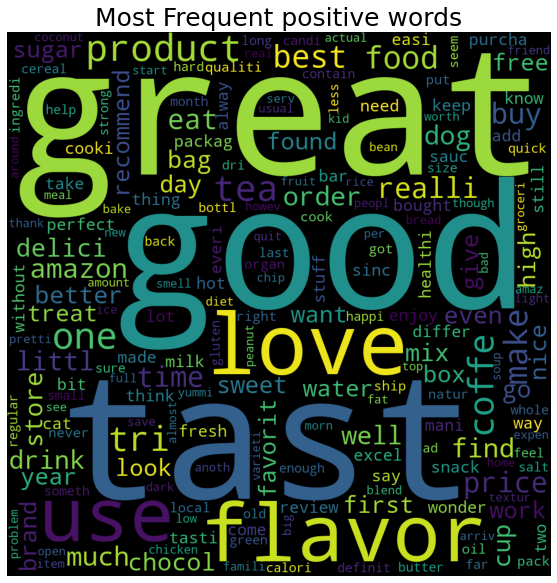

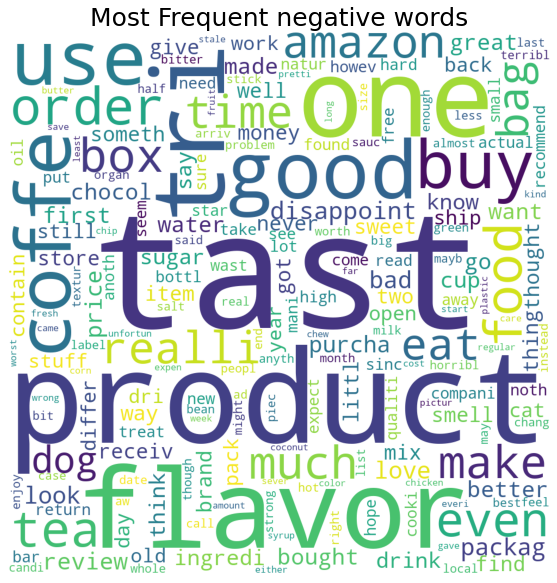

In [9]:
#ploting wordclouds to get most frequent words 
plt.figure(figsize=(10,10))

positive_text = amazon_data_positive.values
positive_cloud = WordCloud(stopwords=STOPWORDS,background_color='black',collocations=False,width=1000,height=1000
                         ).generate(" ".join(positive_text))
plt.axis('off')
plt.title("Most Frequent positive words",fontsize=25)
plt.imshow(positive_cloud)



#owrd cloud of most frequent negative words 
plt.figure(figsize=(10,10))
negative_text = amazon_data_negative.values
negative_cloud = WordCloud(stopwords=STOPWORDS,background_color='white',collocations=False,width=1000
                           ,height=1000 ).generate(" ".join(negative_text))
plt.axis('off')
plt.title("Most Frequent negative words",fontsize=25)
plt.imshow(negative_cloud)

# Training on BOW Features

## Time Based Splitting

In [10]:
#taking first 70% data_points as training data and rest as test_data
X_train_bow = final_bigram_counts[0:int(final_bigram_counts.shape[0]*0.7)]
X_test_bow = final_bigram_counts[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

y_train = amazon_data["Score"].iloc[0:int(final_bigram_counts.shape[0]*0.7)]
y_test = amazon_data["Score"].iloc[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

## Hyper-Parameter Search

In [11]:
#importing required libraries 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import numpy as np
from tqdm.auto import tqdm

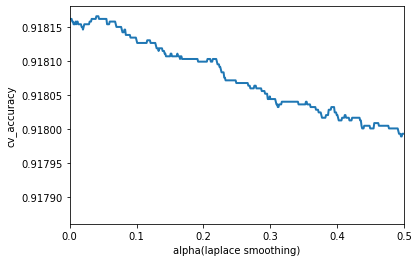

the optimal value for laplace smoothing is : 0.04


In [12]:

#finding the optimal alpha value
alpha_list_bow = list(np.arange(10**-3,1.0,0.001))

cv_scores_bow = []

#performing 10-fold cross_validation to find optimal - aplha value

# perform 10-fold cross validation
for a in tqdm(alpha_list_bow):
    NB_bow = MultinomialNB(alpha = a ,fit_prior =True ,class_prior =None)
    scores_bow = cross_val_score(NB_bow, X_train_bow, y_train, cv=5, scoring='accuracy')
    cv_scores_bow.append(scores_bow.mean())
    
    
    
#plot between cv_scores and alpha values
plt.plot(alpha_list_bow ,  cv_scores_bow ,linewidth = 2.0 , linestyle="-")
plt.xlim(0,0.5)
plt.ylabel("cv_accuracy")
plt.xlabel("alpha(laplace smoothing)")
plt.show()    
    
#getting the optimal_aplha-value
optimal_alpha_bow = alpha_list_bow[cv_scores_bow.index(max(cv_scores_bow))]
print("the optimal value for laplace smoothing is : {}".format(optimal_alpha_bow))

## Predict on test data with best hyper-parameters

In [13]:
#initializing Naive bayes to find test_accuracy with optimal laplace smoothing
NB_bow = MultinomialNB(alpha = optimal_alpha_bow ,fit_prior =True ,class_prior =None)

#fitting the NB model
NB_bow.fit(X_train_bow,y_train)

#predicting for test_data 
NB_pred_bow = NB_bow.predict(X_test_bow)

NB_pred_train_bow = NB_bow.predict(X_train_bow)


#computing accuracy on test_data 
acc_NB_bow = accuracy_score(y_test,NB_pred_bow)*100
test_error_bow = (100-acc_NB_bow)
train_error_bow =( 1-accuracy_score(y_train,NB_pred_train_bow))*100
                  
                  
print("test accuracy using NB : {0:.2f}%" .format(round(acc_NB_bow,2)))
print("test error using NB : {0:.2f}%" .format(round(test_error_bow,2)))
print("train error using NB : {0:.2f}%" .format(round(train_error_bow,2)))

test accuracy using NB : 91.20%
test error using NB : 8.80%
train error using NB : 7.92%


In [14]:
#getting precision,recall,f1-score and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_bow = precision_score(y_test,NB_pred_bow)*100
recall_bow = recall_score(y_test,NB_pred_bow)*100
f1_bow = f1_score(y_test,NB_pred_bow)*100



def confusion_matrix_values(m, n):
    cm = confusion_matrix(m, n)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1])  


TN, FN, FP, TP = confusion_matrix_values(y_test, NB_pred_bow)


print("precision score using NB classifier is : {0:.2f}%".format(round(precision_bow,2)))

print("Recall score using NB classifier is : {0:.2f}%" .format(round(recall_bow,2)))

print("F1-score using NB classifier is : {0:.2f}%".format(round(f1_bow,2)))

print('True positive = {}'.format(TP))
print('False positive = {}'.format(FP))
print('False negative = {}'.format(FN))
print('True negative = {}'.format(TN))


precision score using NB classifier is : 96.59%
Recall score using NB classifier is : 92.61%
F1-score using NB classifier is : 94.56%
True positive = 83507
False positive = 6668
False negative = 2948
True negative = 16129


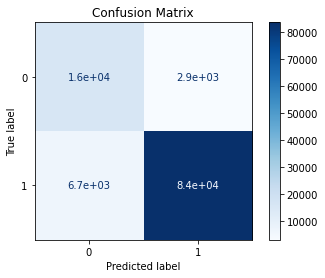

In [15]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(NB_bow, X_test_bow, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show() 

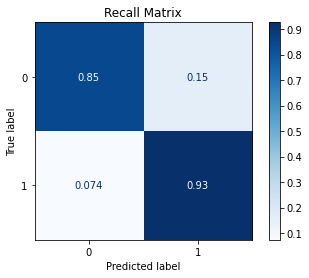

In [16]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(NB_bow, X_test_bow, y_test,cmap=plt.cm.Blues,normalize='true')  
plt.title('Recall Matrix')
plt.show() 

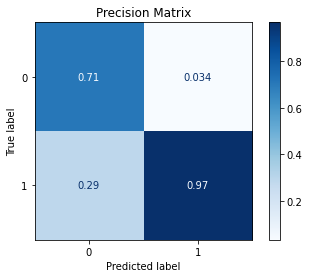

In [17]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(NB_bow, X_test_bow, y_test,cmap=plt.cm.Blues,normalize='pred') 
plt.title('Precision Matrix')
plt.show() 

## Final Result

In [18]:
#reporting the results in a table
from prettytable import PrettyTable

t= PrettyTable()

t.field_names =["metric/Parameter" , "result"]

t.add_row (["Model" ,"Classification"])
t.add_row (["Classifier" ,"Naive-Bayes"])
t.add_row  (["Optimal_alpha" , optimal_alpha_bow])
t.add_row(["test accuracy" ,round(acc_NB_bow,2)])
t.add_row (["Train_error" ,round(train_error_bow,2)])
t.add_row (["Test error" , round(test_error_bow,2)])

In [19]:
print(t)

+------------------+----------------+
| metric/Parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Classifier    |  Naive-Bayes   |
|  Optimal_alpha   |      0.04      |
|  test accuracy   |      91.2      |
|   Train_error    |      7.92      |
|    Test error    |      8.8       |
+------------------+----------------+


# Training on TFIDF Features

## Time Based Splitting

In [20]:
#taking first 70% data_points as training data and rest as test_data
X_train_tfidf = text_tf_idf[0:int(final_bigram_counts.shape[0]*0.7)]
X_test_tfidf = text_tf_idf[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

y_train = amazon_data["Score"].iloc[0:int(final_bigram_counts.shape[0]*0.7)]
y_test = amazon_data["Score"].iloc[int(final_bigram_counts.shape[0]*0.7):final_bigram_counts.shape[0]]

## Hyper Parameter Search

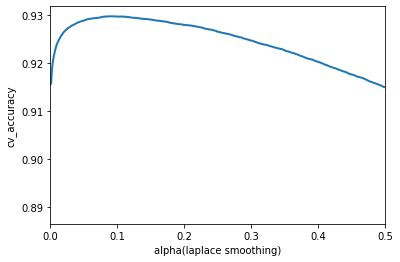

the optimal value for laplace smoothing is :0.08800000000000001


In [21]:

#finding the optimal alpha value
alpha_list_bow = list(np.arange(10**-3,1.0,0.001))

cv_scores_bow = []

#performing 10-fold cross_validation to find optimal - aplha value

# perform 10-fold cross validation
for a in tqdm(alpha_list_bow):
    NB_tfidf = MultinomialNB(alpha = a ,fit_prior =True ,class_prior =None)
    scores_tfidf = cross_val_score(NB_tfidf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    cv_scores_bow.append(scores_tfidf.mean())
    
    
    
#plot between cv_scores and alpha values
plt.plot(alpha_list_bow ,  cv_scores_bow ,linewidth = 2.0 , linestyle="-")
plt.xlim(0,0.5)
plt.ylabel("cv_accuracy")
plt.xlabel("alpha(laplace smoothing)")
plt.show()    
    
#getting the optimal_aplha-value
optimal_alpha_tfidf = alpha_list_bow[cv_scores_bow.index(max(cv_scores_bow))]
print("the optimal value for laplace smoothing is :{}".format(optimal_alpha_tfidf))

## Predict on test data with best hyper-parameters 

In [22]:
#initializing Naive bayes to find test_accuracy with optimal laplace smoothing
NB_tfidf = MultinomialNB(alpha = optimal_alpha_tfidf ,fit_prior =True ,class_prior =None)

#fitting the NB model
NB_tfidf.fit(X_train_tfidf,y_train)

#predicting for test_data 
NB_pred_tfidf = NB_tfidf.predict(X_test_tfidf)

NB_pred_train_tfidf = NB_tfidf.predict(X_train_tfidf)


#computing accuracy on test_data 
acc_NB_tfidf = accuracy_score(y_test,NB_pred_tfidf)*100
test_error_tfidf = (100-acc_NB_tfidf)
train_error_tfidf =( 1-accuracy_score(y_train,NB_pred_train_tfidf))*100
                  
                  
print("test accuracy using NB : {0:.2f}%" .format(round(acc_NB_tfidf,2)))
print("test error using NB : {0:.2f}%" .format(round(test_error_tfidf,2)))
print("train error using NB : {0:.2f}%" .format(round(train_error_tfidf,2)))

test accuracy using NB : 92.41%
test error using NB : 7.59%
train error using NB : 4.22%


In [23]:
#getting precision,recall,f1-score and confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision_tfidf = precision_score(y_test,NB_pred_tfidf)*100
recall_tfidf = recall_score(y_test,NB_pred_tfidf)*100
f1_tfidf = f1_score(y_test,NB_pred_tfidf)*100



def confusion_matrix_values(v, u):
    cm = confusion_matrix(v, u)
    return(cm[0][0], cm[0][1],
            cm[1][0], cm[1][1])  


TN1, FN1, FP1, TP1 = confusion_matrix_values(y_test, NB_pred_tfidf)


print("precision score using NB classifier is : {0:.2f}%".format(round(precision_tfidf,2)))

print("Recall score using NB classifier is : {0:.2f}%" .format(round(recall_tfidf,2)))

print("F1-score using NB classifier is : {0:.2f}%".format(round(f1_tfidf,2)))

print('True positive = {}'.format(TP1))
print('False positive = {}'.format(FP1))
print('False negative = {}'.format(FN1))
print('True negative = {}'.format(TN1))


precision score using NB classifier is : 92.99%
Recall score using NB classifier is : 98.21%
F1-score using NB classifier is : 95.53%
True positive = 88560
False positive = 1615
False negative = 6675
True negative = 12402


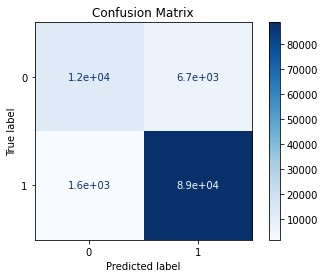

In [24]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(NB_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues)  
plt.title('Confusion Matrix')
plt.show() 

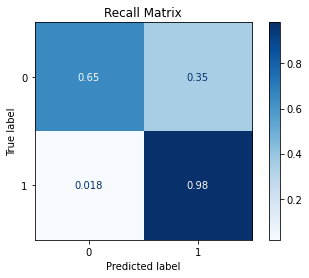

In [25]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(NB_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues,normalize='true')  
plt.title('Recall Matrix')
plt.show() 

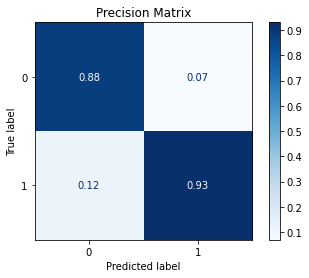

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(NB_tfidf, X_test_tfidf, y_test,cmap=plt.cm.Blues,normalize='pred')  
plt.title('Precision Matrix')
plt.show() 

## Final Result

In [27]:
#reporting the results in a table
from prettytable import PrettyTable

t1= PrettyTable()

t1.field_names =["metric/Parameter" , "result"]

t1.add_row(["Model" ,"Classification"])
t1.add_row (["Classifier" ,"Naive-Bayes"])
t1.add_row  (["Optimal_alpha" , optimal_alpha_tfidf])
t1.add_row(["test accuracy",round(acc_NB_tfidf,2)])
t1.add_row  (["Train_error" ,round(train_error_tfidf,2)])
t1.add_row  (["Test error" , round(test_error_tfidf,2)])

In [28]:
print(t1)

+------------------+---------------------+
| metric/Parameter |        result       |
+------------------+---------------------+
|      Model       |    Classification   |
|    Classifier    |     Naive-Bayes     |
|  Optimal_alpha   | 0.08800000000000001 |
|  test accuracy   |        92.41        |
|   Train_error    |         4.22        |
|    Test error    |         7.59        |
+------------------+---------------------+
